# This script demostrates the Computation of Least square polynomial method(assignment 09)

## Name : Yong-Ho Ahn
## Student ID : 20132465

## import packages for plotting graphs and manipulate data
### And write matplotlib incline for plot error

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## This is the default source code for assignment 08
## only change the bynomial classification

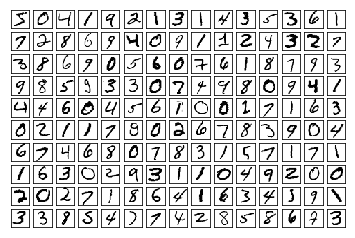

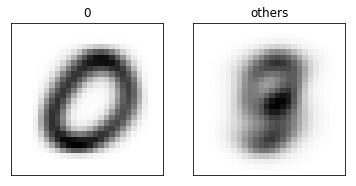

In [2]:
file_data_train = "mnist_train.csv"
file_data_test = "mnist_test.csv"

h_data_train = open(file_data_train, 'r')
h_data_test = open(file_data_test, 'r')

data_train = h_data_train.readlines()
data_test = h_data_test.readlines()

h_data_train.close()
h_data_test.close()

size_row = 28 # height of the image
size_col = 28 # width of the image

num_train = len(data_train) # number of training images
num_test = len(data_test) # number of testing images
#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)
#
# make a matrix each column of which represents an images in a vector form
#

list_image_train = np.empty((size_row * size_col, num_train), dtype=float)
list_label_train = np.empty(num_train, dtype=int)

list_image_test = np.empty((size_row * size_col, num_test), dtype=float)
list_label_test = np.empty(num_test, dtype=int)

count = 0

for line in data_train:
    line_data = line.split(',')
    label = line_data[0]
    
    if label == '0':
        label = 1
    else:
        label = -1
        
    im_vector = np.asfarray(line_data[1:])
    im_vector = normalize(im_vector)
    
    list_label_train[count] = label
    list_image_train[:, count] = im_vector
    
    count += 1
    
count = 0

for line in data_test:
    line_data = line.split(',')
    label = line_data[0]
    
    if label == '0':
        label = 1
    else:
        label = -1
        
    im_vector = np.asfarray(line_data[1:])
    im_vector = normalize(im_vector)
    
    list_label_test[count] = label
    list_image_test[:, count] = im_vector
    
    count += 1
# 
# plot first 150 images out of 10,000 with their labels
# 

f1 = plt.figure(1)

for i in range(150):
    label = list_label_train[i]
    im_vector = list_image_train[:, i]
    im_matrix = im_vector.reshape((size_row, size_col))
    
    plt.subplot(10, 15, i+1)
    #plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')
    
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()
#
# plot the average image of all the images for 0 and others
#

f2 = plt.figure(2)

im_average = np.zeros((size_row * size_col, 2), dtype=float)
im_count = np.zeros(2, dtype=int)

for i in range(num_train):
    if list_label_train[i] == -1:
        im_average[:, 1] += list_image_train[:, i]
        im_count[1] += 1
    else:
        im_average[:, 0] += list_image_train[:, i]
        im_count[0] += 1
    
for i in range(2):
    im_average[:, i] /= im_count[i]
    
    plt.subplot(1, 2, i+1)
    if i == 0:
        plt.title(i)
    else : 
        plt.title('others')
    plt.imshow(
        im_average[:, i].reshape((size_row, size_col)), 
        cmap='Greys', interpolation='None'
    )
    
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    
plt.show()

## Define functions for calculate the F1score

In [3]:
## define norm 
def norm(vector):
    res = 0
    for i in range(len(vector)):
        res += vector[i]**2
    return np.sqrt(res)

## define random
def random(p):
    extractor = np.random.normal(0, 1, (p, 784))
    return extractor

## define projection
def proj(e, a):
    return (np.matmul(e.T, a) / np.matmul(e.T, e))*e

## define QR matrix
def QR(matrix):
    Q = np.zeros([matrix.shape[0], matrix.shape[1]])
    R = np.zeros([matrix.shape[1], matrix.shape[1]])
    U = np.zeros([matrix.shape[1], matrix.shape[0]])
    
    for i in range(matrix.shape[1]):
        sum = 0
        Ai = matrix[:,i]
        for j in range(i):
            sum += proj(U[j], Ai)
        U[i] = Ai - sum
        
    for i in range(matrix.shape[1]):
        for j in range(matrix.shape[0]):
            Q[j][i] = U[i][j]/norm(U[i])
            
    for i in range(matrix.shape[0]):
        for j in range(i, matrix.shape[1]):
            R[i][j] = np.dot(Q[:,i], matrix[:,j])
    return Q, R

## define solve for result
def solve(Q, R, b):
    Rsolve = np.matmul(Q.T, b)
    solve = np.zeros(Rsolve.shape)
    for i in reversed(range(Rsolve.shape[0])):
        a = Rsolve[i]
        for j in reversed(range(i+1, Rsolve.shape[0])):
            a -= solve[j]*R[i][j]
        if R[i][i] == 0:
            solve[i] = 0
        else:
            solve[i] = a / R[i][i]
    return solve

## define F1res(precision, recall)
def F1res(listTF):
    precision = listTF[0] / (listTF[0] + listTF[3])
    recall = listTF[0] / (listTF[0] + listTF[1])
    return 2*((precision * recall) / (precision + recall))

## define TF matrix
def TF(Ran, sol):
    Test = np.matmul(Ran, list_image_test)
    pred = np.sign(np.matmul(Test.T, sol))

    listTF = [None for i in range(num_test)]
    for i in range(num_test):
        if pred[i] == 1.0 and list_label_test[i] == 1:
            listTF[i] = 'TP'
        elif pred[i] == -1.0 and list_label_test[i] == 1:
            listTF[i] = 'FN'
        elif pred[i] == -1.0 and list_label_test[i] == -1:
            listTF[i] = 'TN'
        elif pred[i] == 1.0 and list_label_test[i] == -1:
            listTF[i] = 'FP'

    TFcount = [listTF.count('TP'), listTF.count('FP'), listTF.count('TN'), listTF.count('FN')]
    print("[TP, FP, TN, FN] =", TFcount)
    
    F1 = F1res(TFcount)
    print("F1 =", F1)

    return listTF, F1

## Least square problem
## Calculate F1 score from 100 ~ 1000
## Print Top score

100 feature
[TP, FP, TN, FN] = [872, 74, 8946, 108]
F1 = 0.9055036344755971


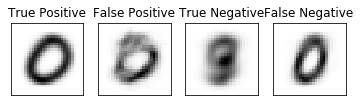

200 feature
[TP, FP, TN, FN] = [891, 63, 8957, 89]
F1 = 0.921406411582213


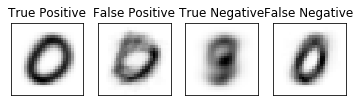

300 feature
[TP, FP, TN, FN] = [912, 62, 8958, 68]
F1 = 0.9334698055271238


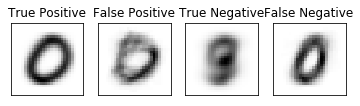

400 feature
[TP, FP, TN, FN] = [913, 60, 8960, 67]
F1 = 0.9349718381976447


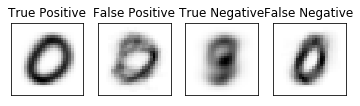

500 feature
[TP, FP, TN, FN] = [918, 61, 8959, 62]
F1 = 0.9372128637059725


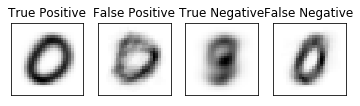

600 feature
[TP, FP, TN, FN] = [917, 59, 8961, 63]
F1 = 0.9376278118609407


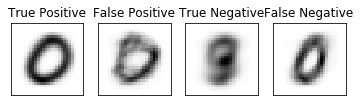

700 feature
[TP, FP, TN, FN] = [917, 61, 8959, 63]
F1 = 0.9366700715015321


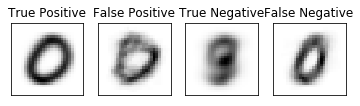

800 feature
[TP, FP, TN, FN] = [926, 80, 8940, 54]
F1 = 0.9325276938569991


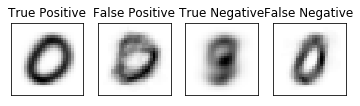

900 feature
[TP, FP, TN, FN] = [918, 64, 8956, 62]
F1 = 0.9357798165137614


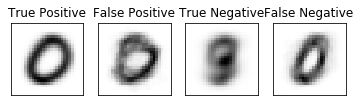

1000 feature
[TP, FP, TN, FN] = [874, 49, 8971, 106]
F1 = 0.9185496584340516


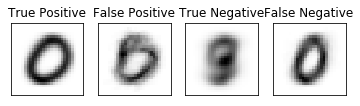

Top F1 score =  0.9376278118609407 , Top F1 num =  600


In [4]:
Top_F1score = 0
Top_F1num = 0

for i in range(100,1100, 100):
    print(str(i), "feature")
    Ran = random(i)
    A = np.matmul(Ran, list_image_train)
    Q, R = np.linalg.qr(A.T)
    sol = solve(Q, R, list_label_train)
    listTF, F1 = TF(Ran, sol)
    if F1 > Top_F1score:
        Top_F1score = F1
        Top_F1num = i
    f3 = plt.figure(3)

    im_average = np.zeros((size_row * size_col, 4), dtype=float)
    im_count = np.zeros(4, dtype=int)
    im_title = ['True Positive', 'False Positive', 'True Negative', 'False Negative']

    for i in range(num_test):
        if listTF[i] == 'TP':
            im_average[:, 0] += list_image_test[:, i]
            im_count[0] += 1
        elif listTF[i] == 'FP':
            im_average[:, 1] += list_image_test[:, i]
            im_count[1] += 1
        elif listTF[i] == 'TN':
            im_average[:, 2] += list_image_test[:, i]
            im_count[2] += 1
        elif listTF[i] == 'FN':
            im_average[:, 3] += list_image_test[:, i]
            im_count[3] += 1

    for i in range(4):
        im_average[:, i] /= im_count[i]

        plt.subplot(1, 4, i+1)
        plt.title(im_title[i])
        plt.imshow(
            im_average[:, i].reshape((size_row, size_col)), 
            cmap='Greys', interpolation='None'
        )

        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)

    plt.show()
    
print("Top F1 score = ", Top_F1score, ", Top F1 num = ", Top_F1num)

## github : https://github.com/anyongho/assignment09